<a href="https://www.kaggle.com/code/hariharan849/vgg16-tensorflow?scriptVersionId=206473361" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,

# THEN FEEL FREE TO DELETE THIS CELL.

# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON

# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR

# NOTEBOOK.

import kagglehub

rahmasleam_flowers_dataset_path = kagglehub.dataset_download('rahmasleam/flowers-dataset')



print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed

# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# For example, here's several helpful packages to load



import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



# Input data files are available in the read-only "../input/" directory

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



import os

for dirname, _, filenames in os.walk('/kaggle/input'):

    for filename in filenames:

        print(os.path.join(dirname, filename))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"

# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flowers-dataset/flower_photos/dandelion/2625836599_03e192266f.jpg
/kaggle/input/flowers-dataset/flower_photos/dandelion/16242239484_51286673af.jpg
/kaggle/input/flowers-dataset/flower_photos/dandelion/5716633491_55e6f02645_n.jpg
/kaggle/input/flowers-dataset/flower_photos/dandelion/13651218133_b6eb8e7ed2_m.jpg
/kaggle/input/flowers-dataset/flower_photos/dandelion/8719032054_9a3ce4f0ff.jpg
/kaggle/input/flowers-dataset/flower_photos/dandelion/9472854850_fc9e1db673.jpg
/kaggle/input/flowers-dataset/flower_photos/dandelion/9293460423_7fbb1e3c32_n.jpg
/kaggle/input/flowers-dataset/flower_photos/dandelion/9939430464_5f5861ebab.jpg
/kaggle/input/flowers-dataset/flower_photos/dandelion/2535769822_513be6bbe9.jpg
/kaggle/input/flowers-dataset/flower_photos/dandelion/8720503800_cab5c62a34.jpg
/kaggle/input/flowers-dataset/flower_photos/dandelion/5674707921_1ffd141bab_n.jpg
/kaggle/input/flowers-dataset/flower_photos/dandelion/16159487_3a6615a565_n.jpg
/kaggle/input/flowers-dataset/

***Imports***

In [3]:
import os, pathlib

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd



import keras

import tensorflow as tf

from keras.applications import VGG16

from keras.callbacks import ModelCheckpoint

from keras.utils import image_dataset_from_directory

from keras import layers

***Dataset Preprocessing***

In [4]:
dataset_path = pathlib.Path(os.path.join(rahmasleam_flowers_dataset_path, "flower_photos"))

images = list(dataset_path.glob("*/*"))

labels = [os.path.split(os.path.dirname(image))[-1] for image in images]



dataset = pd.DataFrame(zip(images, labels), columns=["Images", "Labels"])

class_names = dataset["Labels"].unique()

***Count Plot for labels***

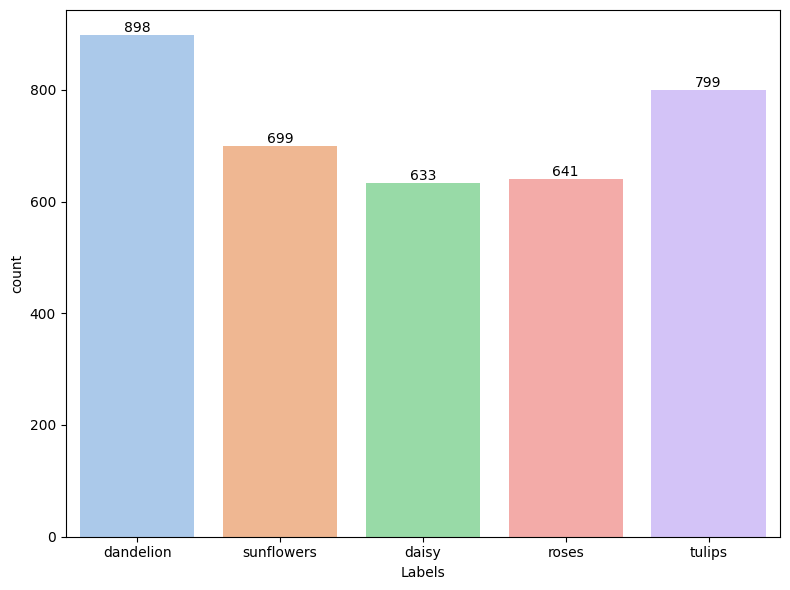

In [5]:
#count Plot

plt.figure(figsize=(8, 6))

ax = sns.countplot(dataset, x="Labels", palette='pastel')



# Annotate the count on top of each bar

for p in ax.patches:

    height = p.get_height()

    ax.annotate(f'{int(height)}',

                (p.get_x() + p.get_width() / 2, height),

                ha='center', va='bottom')



plt.tight_layout()

# Show the plot

plt.show()

***PIE chart for labels***

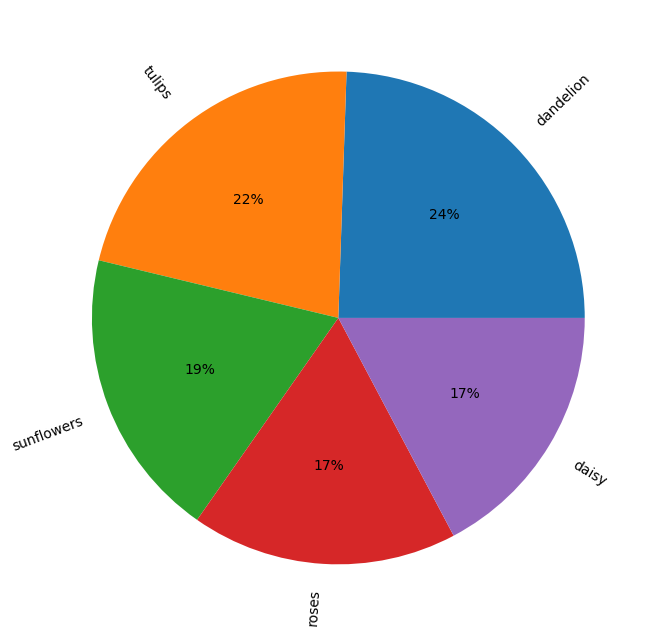

In [6]:
value_counts = dataset["Labels"].value_counts()



plt.figure(figsize=(8, 8))

plt.pie(value_counts, labels=value_counts.index, rotatelabels=True, autopct='%.0f%%')

plt.show()

In [7]:
dataset['Images']

0       /kaggle/input/flowers-dataset/flower_photos/da...
1       /kaggle/input/flowers-dataset/flower_photos/da...
2       /kaggle/input/flowers-dataset/flower_photos/da...
3       /kaggle/input/flowers-dataset/flower_photos/da...
4       /kaggle/input/flowers-dataset/flower_photos/da...
                              ...                        
3665    /kaggle/input/flowers-dataset/flower_photos/tu...
3666    /kaggle/input/flowers-dataset/flower_photos/tu...
3667    /kaggle/input/flowers-dataset/flower_photos/tu...
3668    /kaggle/input/flowers-dataset/flower_photos/tu...
3669    /kaggle/input/flowers-dataset/flower_photos/tu...
Name: Images, Length: 3670, dtype: object

In [8]:
dataset['Images'].dtypes

dtype('O')

In [9]:
# Extract the file extensions, convert to lowercase, and find unique extensions

dataset['extension'] = dataset['Images'].astype(str).str.extract(r'\.([a-zA-Z0-9]+)$', expand=False).str.lower()

unique_extensions = dataset['extension'].unique()

print (unique_extensions)

['jpg']


***Display random images***

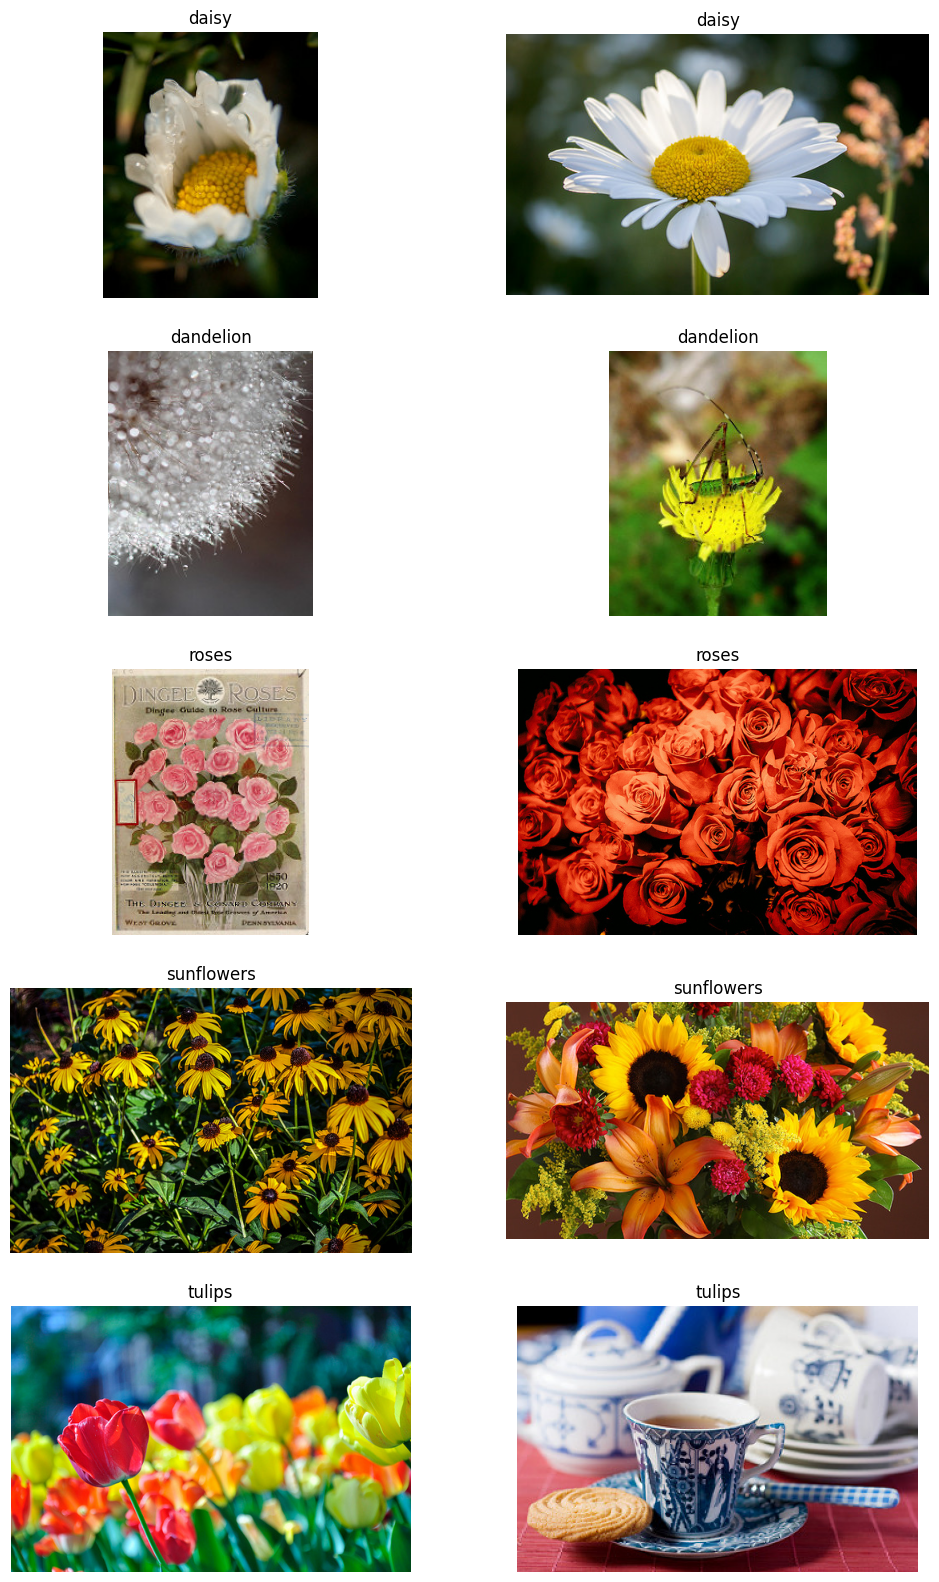

In [10]:
import cv2



random_images = dataset.sample(frac=1).sort_values(by="Labels").groupby('Labels').head(2)



count = 0

num_classes = len(class_names)



plt.figure(figsize=(12, num_classes * 4))

for index, (image_path, class_name, _) in random_images.iterrows():

  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

  count += 1



  plt.subplot(num_classes, 2, count)



  plt.imshow(image)

  plt.axis('off')

  plt.title(class_name)



***Dataset Preperation***

In [11]:
batch_size = 32

img_height = 224

img_width = 224



train_dataset = image_dataset_from_directory(

    directory=dataset_path,

    labels="inferred",         # Automatically infer labels from subdirectory names

    label_mode="categorical",  # Options: 'int', 'categorical', 'binary'

    batch_size=batch_size,

    image_size=(img_height, img_width),      # Resize all images to this size

    shuffle=True,               # Shuffle the dataset

    seed=42,                    # Set a seed for reproducibility

    validation_split=0.2,       # Use 20% of the data for validation

    subset="training",          # Use "training" or "validation" subsets

)



val_dataset = image_dataset_from_directory(

    directory=dataset_path,

    labels="inferred",         # Automatically infer labels from subdirectory names

    label_mode="categorical",  # Options: 'int', 'categorical', 'binary'

    batch_size=batch_size,

    image_size=(img_height, img_width),      # Resize all images to this size

    shuffle=True,               # Shuffle the dataset

    seed=42,                    # Set a seed for reproducibility

    validation_split=0.2,       # Use 20% of the data for validation

    subset="validation",        # Use "training" or "validation" subsets

)



AUTOTUNE = tf.data.AUTOTUNE



train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


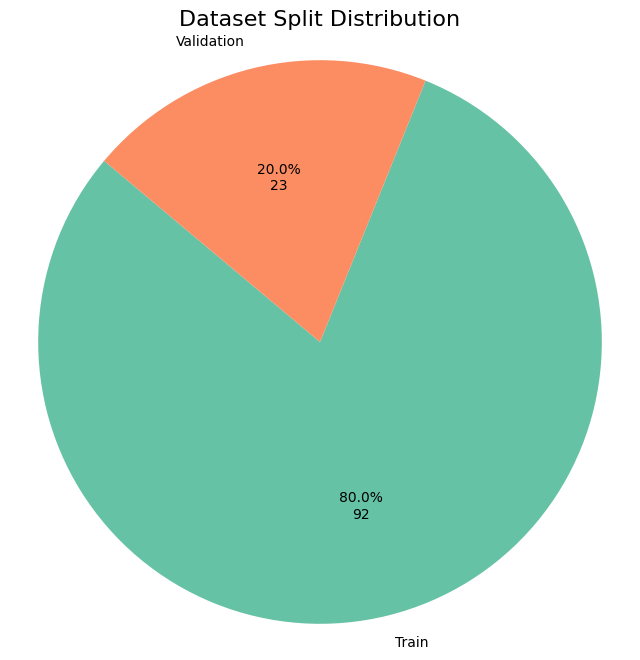

In [12]:
train_size = len(train_dataset)

validation_size = len(val_dataset)



# Dataset sizes

sizes = [train_size, validation_size]

labels = ['Train', 'Validation']

colors = ['#66c2a5', '#fc8d62']





def autopct_format(value):

    """Formats the autopct value to display the percentage and count."""

    total = sum(sizes)

    percentage = f'{value:.1f}%'

    count = int(value * total / 100)

    return f'{percentage}\n{count}'



# Create a pie chart

plt.figure(figsize=(8, 8))

plt.pie(sizes, labels=labels, colors=colors, autopct=autopct_format, startangle=140)

plt.title('Dataset Split Distribution', fontsize=16)

plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

plt.show()

***Model***

In [13]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

# Enable the last 5 layers of VGG16 to be trainable

for layer in base_model.layers[-5:]:  # Last 5 layers

    layer.trainable = True



augment_layer = keras.Sequential(

    [

      layers.RandomFlip("horizontal"),

      layers.RandomRotation(0.2),

      layers.RandomZoom(0.2)

    ]

)



input_shape = (224, 224, 3)



inputs = layers.Input(shape=input_shape, name="input_layer")

x = augment_layer(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation='relu')(x)  # Add a fully connected layer

x = layers.Dropout(0.5)(x)                   # Dropout layer for regularization

outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)



model_vgg = keras.Model(inputs, outputs)

model_vgg.compile(loss="categorical_crossentropy",

    optimizer=keras.optimizers.Adam(learning_rate=0.0001),

    metrics=["accuracy"]

)



model_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,909 (57.14 MB)

 Trainable params: 7,344,645 (28.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [14]:
checkpoint = ModelCheckpoint('best_val_acc_model.weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', save_weights_only=True)



# Calculate the steps per epoch

train_steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()



history = model_vgg.fit(train_ds,

                    epochs=10,

                    validation_data=val_ds,

                    callbacks=[checkpoint], verbose=1

                  )

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 296ms/step - accuracy: 0.3430 - loss: 1.9776 - val_accuracy: 0.7343 - val_loss: 0.7939
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.7056 - loss: 0.7864 - val_accuracy: 0.8351 - val_loss: 0.4495
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.8391 - loss: 0.4668 - val_accuracy: 0.8733 - val_loss: 0.3785
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.8468 - loss: 0.4410 - val_accuracy: 0.8856 - val_loss: 0.3539
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.8742 - loss: 0.3686 - val_accuracy: 0.8896 - val_loss: 0.3475
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.8936 - loss: 0.2965 - val_accuracy: 0.8910 - val_loss: 0.3829
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.9083 - loss: 0.2629 - val_accuracy: 0.8978 - val_loss: 0.3567
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.9192 - loss: 0.2237 - val_accu

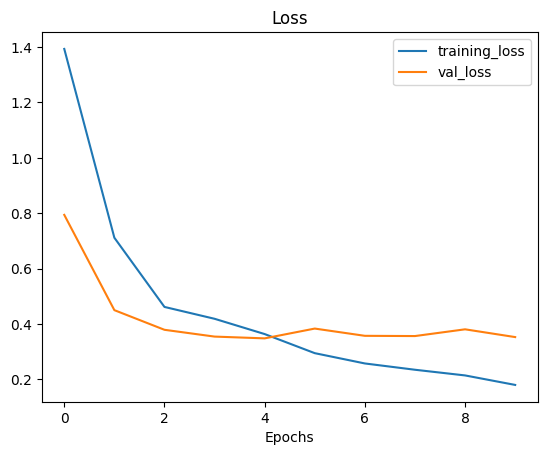

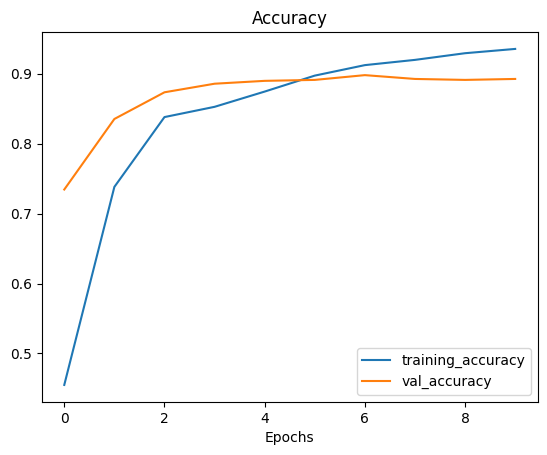

In [15]:
def plot_loss_curves(history):

  """

  Returns separate loss curves for training and validation metrics.



  Args:

    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)

  """

  loss = history.history['loss']

  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']

  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))



  # Plot loss

  plt.plot(epochs, loss, label='training_loss')

  plt.plot(epochs, val_loss, label='val_loss')

  plt.title('Loss')

  plt.xlabel('Epochs')

  plt.legend()



  # Plot accuracy

  plt.figure()

  plt.plot(epochs, accuracy, label='training_accuracy')

  plt.plot(epochs, val_accuracy, label='val_accuracy')

  plt.title('Accuracy')

  plt.xlabel('Epochs')

  plt.legend();





plot_loss_curves(history)